# CLUE : Clustering for Mining Web URL

We aim at finding a method for digging inside a data set of URLs. The main purpose is the obtention of a clustering workflow that would allow us to directly get segments of similar URLs from stream-like data with no need for manual rule creation.

Part of this work began in the notebook APD_Structure-URL https://colab.research.google.com/drive/1MFrvUJTGmmvTe_WAI8HmI-QeTkzwXEix with some exploratory data analysis and application of URL transformation based on pattern tree construction rules.

Work presented on the current notebook is based on work from Morichetta et al.  (2017) who developed a non-specific tool for analysing massive URL data sets using text-mining methods https://www.researchgate.net/publication/312183704_CLUE_Clustering_for_Mining_Web_URLs

## Import URL data

In [1]:
from google.colab import auth
auth.authenticate_user()
import sys
import numba as nb

import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.cluster import dbscan
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize': (8,8)})

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'tr-tech-innovation-dev'

df_url = pd.io.gbq.read_gbq(
    '''
    SELECT
    *
    FROM `tr-tech-innovation-dev.ADP.debug_table`
    ''', 
    project_id=project_id)
df_url = df_url.loc[pd.notna(df_url['name'])]
df_url = df_url.rename(columns={'dv360_url': 'url',
                                'name': 'segment_name',
                                'url_count': 'impressions'})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print('Total URL: %i' %len(df_url['url']))
print('Unique URL: %i' %df_url['url'].nunique())

Total URL: 35969
Unique URL: 10411


## 1. URL-distances

URL distance computation does not have real-time constriants and can be schedule when the data collection is complete, or also on demand.

The concept of **distance** refers to a specific class of dissimilarity measures that aim at quantifying how much two points $x_1$ and $x_2$ are far apart in a numerical way. A dissimilarity measure must meet 3 propreties in order to be called a distance :

- **positivity** : $\forall (x_1, x_2), d(x_1, x_2) \geq 0$ ; $d(x_1, x_2) = 0 \iff x_1 = x_2$
- **symmetry** : $\forall (x_1, x_2), d(x_1, x_2) = d(x_2, x_1)$
- **triangle inequality** : $\forall (x_1, x_2, x_3), d(x_1, x_3) \leq d(x_1, x_2) + d(x_2, x_3)$

Let's bear in mind that in order to facilitate the clustering of URLs (which is our main goal), we want to keep distances between URLs concentrated within given ranges.

### 1.1 Levenshtein distance

The Levenshtein distance $d_{LVS}(s_1, s_2)$ assigns a unitary cost for all editing operations (insert, remove, replace). It computes an absolute distance  between pairs of strings that is **at most equal to the length of the longest string**. This has to be kept in mind as it might make the Levensthein distance inconvenient when it comes to comparing a very short URL against a very long one.

The Levenshtein distance is defined as:

$d_{LVS}(i,j) = \max(i,j)$ if $\min(i,j) = 0$

$d_{LVS}(i,j) = \min(d_{LVS}(i-1, j),~d_{LVS}(i, j-1),~d_{LVS}(i-1, j-1)+I(s_{1i}\neq s_{2i}))$ otherwise

Where $d_{LVS}(i,j)$ is the distance between the first $i$ characters of $s_1$ and the first $j$ characters of $s_2$ and $I$ is the indicator function, here equal to $0$ when $s_{1i} = s_{2j}$

In [3]:
def levenshtein_distance(s1, s2):
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return np.float64(0)
  elif l1 == 0:
    return np.float64(l2)
  elif l2 == 0:
    return np.float64(l1)
  
  v0 = np.array([None]*(l2+1))
  v1 = np.array([None]*(l2+1))
  for i in range(len(v0)):
    v0[i] = i
  for i in range(l1):
    v1[0] = i+1
    for j in range(l2):
      if s1[i] == s2[j]:
        C = np.float64(0)
      else:
        C = np.float64(1)
      v1[j+1] = min(v1[j]+1, v0[j+1]+1, v0[j]+C)
    for j in range(len(v0)):
      v0[j] = v1[j]

  return v1[l2]

### 1.2 Jaro distance

The Jaro distance $d_{JRO}(s_1, s_2)$ considers **the number and the order  of common characters between two strings**.

$d_{JRO} = 1$ if $m = 0$

$d_{JRO} = 1 - \frac{1}{3}(\frac{m}{|s_1|}+\frac{m}{|s_2|}+\frac{m-t}{m})$ otherwise

where $m$ is the number of matching characters and $t$ is half the number of  transpositions.

In [4]:
def jaro_distance(s1, s2):
  l1, l2 = len(s1), len(s2)

  if l1 == 0 and l2 == 0:
    return np.float64(1)
  
  match_distance = max(l1, l2)//2 - 1
  s1_matches = np.array([None]*l1)
  s2_matches = np.array([None]*l2)

  m, t = np.float64(0), np.float64(0)

  for i in range(l1):
    start = max(0, i-match_distance)
    end = min(i+match_distance+1, l2)

    for j in range(start, end):
      if s2_matches[j]:
        continue
      if s1[i] != s2[j]:
        continue
      s1_matches[i] = True
      s2_matches[j] = True
      m += np.float64(1)
      break
  
  if m == 0:
    return np.float64(1)
  
  k = 0
  for i in range(l1):
    if not s1_matches[i]:
      continue
    while not s2_matches[k]:
      k += 1
    if s1[i] != s2[k]:
      t += 1
    k += 1

  return np.float64(1-(1./3)*(m/l1+m/l2+(m-t/2)/m))

### 1.3 URL distance

This distance calculation $d_{URL}$ is inspired from a custom modification of the Levenshtein distance $d_{LVS_2}$. Here total number of insertions and deletions are counted and **replacement is weighted by a factor of 2**. In the end, a replacement is considered as the combination of an insertion and a deletion. **String length is also considered and results are normalised in $[0,1]$**.

$d_{URL}(s_1, s_2) = 1 - \frac{|s_1|+|s_2|-d_{LVS_2}(s_1, s_2)}{|s_1|+|s_2|}$

we get $d_{URL}(s_1, s_2) = 0 \iff s_1 = s_2$ and $d_{URL}(s_1, s_2) = 1$ if $s_1$ and $s_2$ are totally different.

In [102]:
def levenshtein_distance2(s1, s2):
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return np.float64(0)
  elif l1 == 0:
    return np.float64(l2)
  elif l2 == 0:
    return np.float64(l1)
  
  v0 = np.array([None]*(l2+1))
  v1 = np.array([None]*(l2+1))
  for i in range(len(v0)):
    v0[i] = i
  for i in range(l1):
    v1[0] = i+1
    for j in range(l2):
      if s1[i] == s2[j]:
        C = np.float64(0)
      else:
        C = np.float64(2)
      v1[j+1] = min(v1[j]+1, v0[j+1]+1, v0[j]+C)
    for j in range(len(v0)):
      v0[j] = v1[j]

  return v1[l2]

def url_distance(s1, s2):
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return np.float64(0)
  elif l1 == 0:
    return np.float64(l2)
  elif l2 == 0:
    return np.float64(l1)

  return np.float64(1 - (l1+l2-levenshtein_distance2(s1, s2))/(l1+l2))

In [6]:
def levenshtein_distance2_nonumpy(s1, s2):
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return 0
  elif l1 == 0:
    return l2
  elif l2 == 0:
    return l1
  
  v0 = [None]*(l2+1)
  v1 = [None]*(l2+1)
  for i in range(len(v0)):
    v0[i] = i
  for i in range(l1):
    v1[0] = i+1
    for j in range(l2):
      if s1[i] == s2[j]:
        C = 0
      else:
        C = 2
      v1[j+1] = min(v1[j]+1, v0[j+1]+1, v0[j]+C)
    for j in range(len(v0)):
      v0[j] = v1[j]

  return v1[l2]

def url_distance_nonumpy(s1, s2):
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return 0
  elif l1 == 0:
    return l2
  elif l2 == 0:
    return l1

  return 1 - (l1+l2-levenshtein_distance2_nonumpy(s1, s2))/(l1+l2)

In [7]:
s1, s2 = 'google.com', '1goggle.com'

In [8]:
%%timeit
levenshtein_distance(s1, s2)

1000 loops, best of 3: 204 µs per loop


In [9]:
%%timeit
jaro_distance(s1, s2)

10000 loops, best of 3: 24.4 µs per loop


In [10]:
%%timeit
url_distance(s1, s2)

1000 loops, best of 3: 199 µs per loop


In [11]:
%%timeit
url_distance_nonumpy(s1, s2)

10000 loops, best of 3: 51.8 µs per loop


In [103]:
#CLUE article test example
s1, s2 = 'google.com', '1goggle.com'
print('dLVS(\'{}\', \'{}\') = %s'.format(s1, s2)  %np.round(levenshtein_distance(s1, s2),3))
print('dJRO(\'{}\', \'{}\') = %s'.format(s1, s2)  %np.round(jaro_distance(s1, s2),3))
print('dURL(\'{}\', \'{}\') = %s'.format(s1, s2)  %np.round(url_distance(s1, s2),3))

#
#dLVS('google.com', '1goggle.com') = 2
#dJRO('google.com', '1goggle.com') = 0.094
#dURL('google.com', '1goggle.com') = 0.143
#

dLVS('google.com', '1goggle.com') = 2.0
dJRO('google.com', '1goggle.com') = 0.094
dURL('google.com', '1goggle.com') = 0.143


### 1.4 Distances CDF and distance measure selection

#### 1.4.1 Format URLs 

In [ ]:
U = df_url['url'].drop_duplicates().sample(frac=0.005).to_numpy(dtype='str')
print('Unique URL: %i' %len(U))

Unique URL: 52


#### 1.4.2 Levenshtein distance

CPU times: user 12.6 s, sys: 7.37 ms, total: 12.6 s
Wall time: 12.6 s


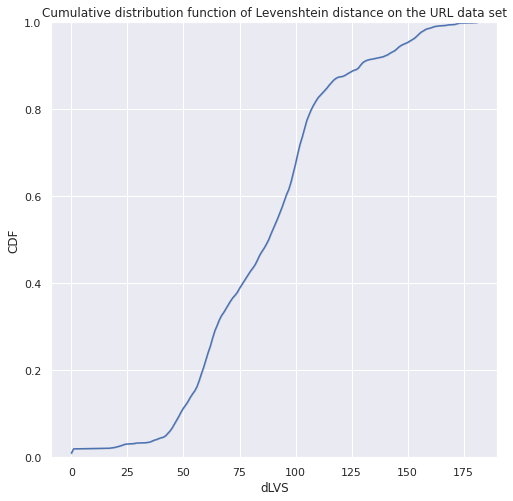

In [ ]:
%%time
#calculate distances between each pair of URLs
lvs_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      lvs_matrix[i,j] = np.round(levenshtein_distance(U[i],U[j]),2)

#build CDF array
to_plot_lvs = lvs_matrix.ravel()
to_plot_lvs_sorted = np.sort(to_plot_lvs)
p = 1.*np.arange(len(to_plot_lvs))/(len(to_plot_lvs)-1)

#plot CDF
plot = sns.lineplot(to_plot_lvs_sorted, p)
plot.set(title='Cumulative distribution function of Levenshtein distance on the URL data set',
         xlabel='dLVS',
         ylabel='CDF');
plot.set(ylim=[0, 1]);    

#### 1.4.3 Jaro distance

CPU times: user 4.99 s, sys: 10 ms, total: 5 s
Wall time: 5 s


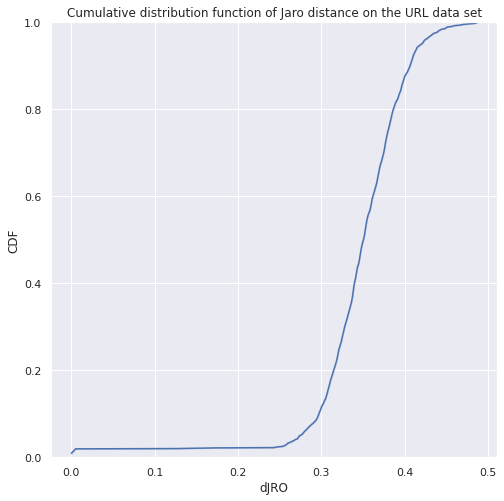

In [ ]:
%%time
#calculate distances between each pair of URLs
jro_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      jro_matrix[i,j] = np.round(jaro_distance(U[i],U[j]),3)

#build CDF array
to_plot_jro = jro_matrix.ravel()
to_plot_jro_sorted = np.sort(to_plot_jro)
p = 1.*np.arange(len(to_plot_jro))/(len(to_plot_jro)-1)

#plot CDF
plot = sns.lineplot(to_plot_jro_sorted, p)
plot.set(title='Cumulative distribution function of Jaro distance on the URL data set',
         xlabel='dJRO',
         ylabel='CDF');
plot.set(ylim=[0, 1]);       

#### 1.4.4 URL distance

CPU times: user 15.7 s, sys: 4.95 ms, total: 15.7 s
Wall time: 15.7 s


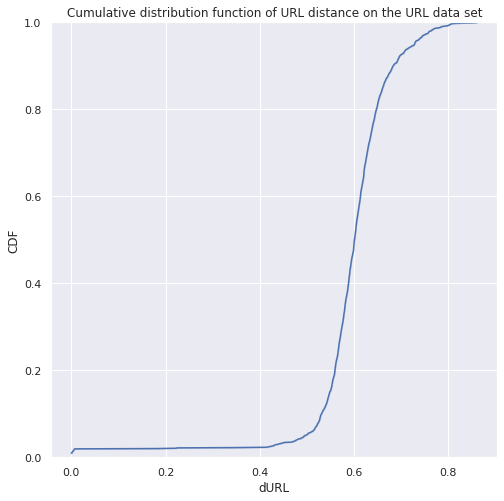

In [ ]:
%%time
#calculate distances between each pair of URLs
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),3)
#print(url_matrix)

#build CDF array
to_plot_url = url_matrix.ravel()
to_plot_url_sorted = np.sort(to_plot_url)
p = 1.*np.arange(len(to_plot_url))/(len(to_plot_url)-1)

#plot CDF
plot = sns.lineplot(to_plot_url_sorted, p)
plot.set(title='Cumulative distribution function of URL distance on the URL data set',
         xlabel='dURL',
         ylabel='CDF');
plot.set(ylim=[0, 1]);

## 2. URL clustering

Here we aim at grouping together points according to the $d_{URL}$ distance function introduced above. URLs grouped in the same cluster share common features and we'll see if we can further consider that they represent a segment.

Clustering is performed using **DBSCAN**, a density-based clustering method, which shows several advantages over centroid-based approaches (such as *k-means clustering*):
- there is no need for prior knowledge of the total number of clusters
- arbitrarily-shaped clusters can be discovered
- outliers are considered and some may be left apart clustering as noise

Illustration : let us consider a set of points in a sample space to be clustered. Let $d(x_1, x_2)$ be the distance between two points $x_1$ and $x_2$. Consider now the sphere of radius $r$ centered in $x_1$. If at least $minPoints$ are within distance $d \leq r$ from $x_1$, then $x_1$ is classified as **core point**. The $minPoints$ are defiend as *directly reachable* from $x_1$. 
A given point $x_k$ is said to be *reachable* from $x_1$ if there exists a path $x_1, x_2, \dots, x_k$ so that $x_{i+1}$ is directly reachable from $x_i$. The subset of reachable points from $x_1$ form a **cluster**, i.e. a **dense region**. 
Points that are not reachable from $x_1$ are **outliers**, they may form a separate cluster if they fall in a separate dense region, or remain in the noise region as outliers.

Although $minPoints$ and $r$ can be tuned by the user, the critical parameter is $r$, the radius of the sphere that indeed defines the enveloppe of the cluster. A too small value of $r$ would lead to a too high number of clusters and outliers, whereas a too large value of $r$ would lead to a too small number of clusters, showing heterogeneity. Authors even warn about the fact that choice of $r$ needs a preliminary study since it can completely change clustering results.

### Radius $r$ sensitivity analysis

We use $d_{URL}$ as the distance measure between the URLs we want to cluster. Since $d_{URL} \in [0, 1]$ by construction, we choose to make $r$ vary within a range at first. Following we compute a sort of *grid search* over parameters $r$ and $minPoints$

Unique URL: 521

CPU times: user 15min 56s, sys: 123 ms, total: 15min 56s
Wall time: 15min 57s


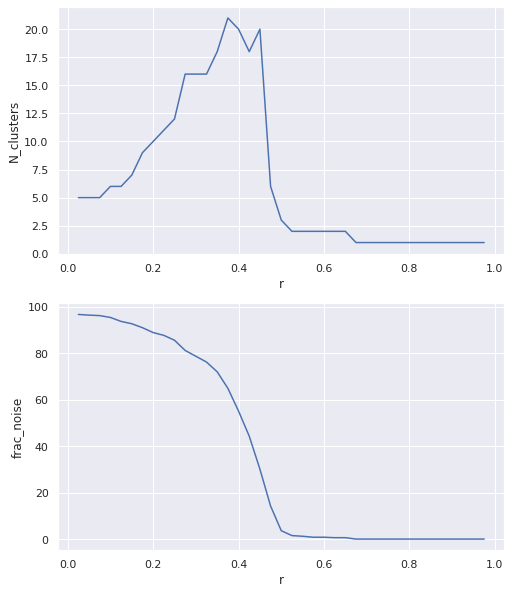

In [ ]:
%%time
U = df_url['url'].drop_duplicates().sample(frac=0.05).tolist()
print('Unique URL: %i\n' %len(U))
array_U = np.arange(len(U)).reshape(-1, 1)

#calculate distances between each pair of URLs using url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),4)

clustering_results = {'r': [],
                      'minPoints': [],
                      'N_clusters': [],
                      'Noise_elements': []}
for r in np.arange(.025, 1, 0.025):
  for minPoints in np.arange(1,11):
    res_tmp = dbscan(url_matrix, 
                     metric='precomputed', 
                     eps=np.round(r, 3), 
                     min_samples=minPoints)
    n_clusters_tmp = len(np.unique(res_tmp[1]))
    n_noise_tmp = np.count_nonzero(res_tmp[1]==-1)
    
    #update results dictionary
    clustering_results['r'].append(r)
    clustering_results['minPoints'].append(minPoints)
    clustering_results['N_clusters'].append(n_clusters_tmp)
    clustering_results['Noise_elements'].append(n_noise_tmp)
    
#output results to data frame
df_res = pd.DataFrame(clustering_results)
df_res['frac_noise'] = np.round(100.*df_res['Noise_elements']/len(U), 1)
df_clusters = df_res[df_res['minPoints']==4][['r', 'N_clusters']].reset_index(drop=True)
df_noise = df_res[df_res['minPoints']==4][['r', 'frac_noise']].reset_index(drop=True)

#display results
plt.figure(figsize=(8,10))
plt.subplot(2, 1, 1);
sns.lineplot(x=df_clusters['r'], 
              y=df_clusters['N_clusters']);
plt.subplot(2, 1, 2);
sns.lineplot(x=df_noise['r'],
              y=df_noise['frac_noise']);

Unique URL: 1041

CPU times: user 1h 1min 49s, sys: 461 ms, total: 1h 1min 49s
Wall time: 1h 1min 52s


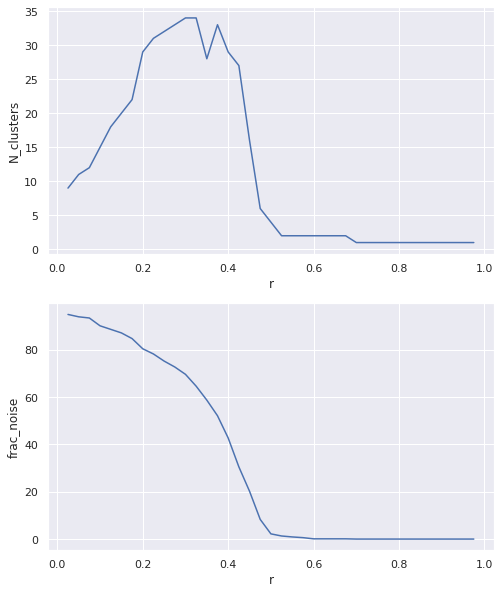

In [ ]:
%%time
U = df_url['url'].drop_duplicates().sample(frac=0.1).tolist()
print('Unique URL: %i\n' %len(U))
array_U = np.arange(len(U)).reshape(-1, 1)

#calculate distances between each pair of URLs using url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),4)

clustering_results = {'r': [],
                      'minPoints': [],
                      'N_clusters': [],
                      'Noise_elements': []}
for r in np.arange(.025, 1, 0.025):
  for minPoints in np.arange(1,11):
    res_tmp = dbscan(url_matrix, 
                     metric='precomputed', 
                     eps=np.round(r, 3), 
                     min_samples=minPoints)
    n_clusters_tmp = len(np.unique(res_tmp[1]))
    n_noise_tmp = np.count_nonzero(res_tmp[1]==-1)
    
    #update results dictionary
    clustering_results['r'].append(r)
    clustering_results['minPoints'].append(minPoints)
    clustering_results['N_clusters'].append(n_clusters_tmp)
    clustering_results['Noise_elements'].append(n_noise_tmp)
    
#output results to data frame
df_res = pd.DataFrame(clustering_results)
df_res['frac_noise'] = np.round(100.*df_res['Noise_elements']/len(U), 1)
df_clusters = df_res[df_res['minPoints']==4][['r', 'N_clusters']].reset_index(drop=True)
df_noise = df_res[df_res['minPoints']==4][['r', 'frac_noise']].reset_index(drop=True)

#display results
plt.figure(figsize=(8,10))
plt.subplot(2, 1, 1);
sns.lineplot(x=df_clusters['r'], 
              y=df_clusters['N_clusters']);
plt.subplot(2, 1, 2);
sns.lineplot(x=df_noise['r'],
              y=df_noise['frac_noise']);

Unique URL: 2082

CPU times: user 4h 20min 39s, sys: 2.18 s, total: 4h 20min 41s
Wall time: 4h 20min 54s


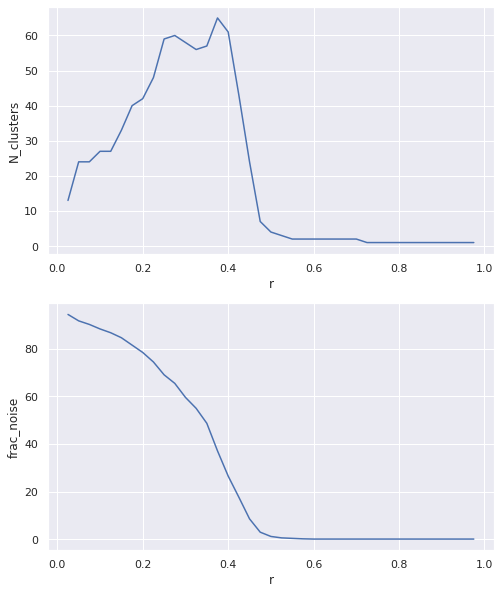

In [ ]:
%%time
U = df_url['url'].drop_duplicates().sample(frac=0.2).tolist()
print('Unique URL: %i\n' %len(U))
array_U = np.arange(len(U)).reshape(-1, 1)

#calculate distances between each pair of URLs using url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),4)

clustering_results = {'r': [],
                      'minPoints': [],
                      'N_clusters': [],
                      'Noise_elements': []}
for r in np.arange(.025, 1, 0.025):
  for minPoints in np.arange(1,11):
    res_tmp = dbscan(url_matrix, 
                     metric='precomputed', 
                     eps=np.round(r, 3), 
                     min_samples=minPoints)
    n_clusters_tmp = len(np.unique(res_tmp[1]))
    n_noise_tmp = np.count_nonzero(res_tmp[1]==-1)
    
    #update results dictionary
    clustering_results['r'].append(r)
    clustering_results['minPoints'].append(minPoints)
    clustering_results['N_clusters'].append(n_clusters_tmp)
    clustering_results['Noise_elements'].append(n_noise_tmp)
    
#output results to data frame
df_res = pd.DataFrame(clustering_results)
df_res['frac_noise'] = np.round(100.*df_res['Noise_elements']/len(U), 1)
df_clusters = df_res[df_res['minPoints']==4][['r', 'N_clusters']].reset_index(drop=True)
df_noise = df_res[df_res['minPoints']==4][['r', 'frac_noise']].reset_index(drop=True)

#display results
plt.figure(figsize=(8,10))
plt.subplot(2, 1, 1);
sns.lineplot(x=df_clusters['r'], 
              y=df_clusters['N_clusters']);
plt.subplot(2, 1, 2);
sns.lineplot(x=df_noise['r'],
              y=df_noise['frac_noise']);

Unique URL: 3123

CPU times: user 9h 27min 47s, sys: 5.64 s, total: 9h 27min 52s
Wall time: 9h 28min 12s


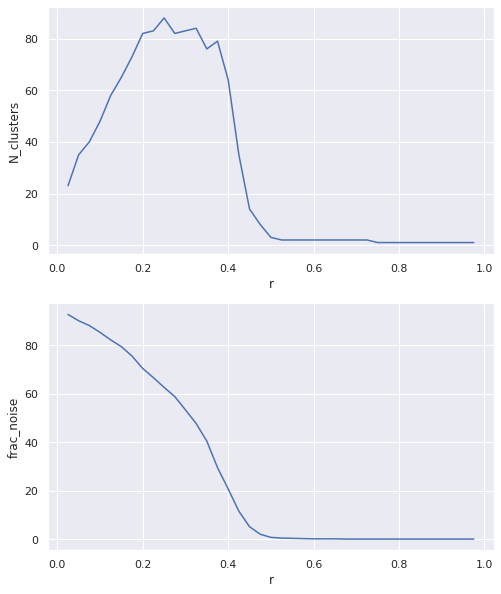

In [ ]:
%%time
U = df_url['url'].drop_duplicates().sample(frac=0.3).tolist()
print('Unique URL: %i\n' %len(U))
array_U = np.arange(len(U)).reshape(-1, 1)

#calculate distances between each pair of URLs using url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),4)

clustering_results = {'r': [],
                      'minPoints': [],
                      'N_clusters': [],
                      'Noise_elements': []}
for r in np.arange(.025, 1, 0.025):
  for minPoints in np.arange(1,11):
    res_tmp = dbscan(url_matrix, 
                     metric='precomputed', 
                     eps=np.round(r, 3), 
                     min_samples=minPoints)
    n_clusters_tmp = len(np.unique(res_tmp[1]))
    n_noise_tmp = np.count_nonzero(res_tmp[1]==-1)
    
    #update results dictionary
    clustering_results['r'].append(r)
    clustering_results['minPoints'].append(minPoints)
    clustering_results['N_clusters'].append(n_clusters_tmp)
    clustering_results['Noise_elements'].append(n_noise_tmp)
    
#output results to data frame
df_res = pd.DataFrame(clustering_results)
df_res['frac_noise'] = np.round(100.*df_res['Noise_elements']/len(U), 1)
df_clusters = df_res[df_res['minPoints']==4][['r', 'N_clusters']].reset_index(drop=True)
df_noise = df_res[df_res['minPoints']==4][['r', 'frac_noise']].reset_index(drop=True)

#display results
plt.figure(figsize=(8,10))
plt.subplot(2, 1, 1);
sns.lineplot(x=df_clusters['r'], 
              y=df_clusters['N_clusters']);
plt.subplot(2, 1, 2);
sns.lineplot(x=df_noise['r'],
              y=df_noise['frac_noise']);

## 3. Distance matrix optimisation

Various solutions may help in saving computation time :
- Using scipy distance.cdist(source written in c) to calculate the distances between all pairs
- Use numpy instead of pandas
- Jit compile the jaccard distance function as it is being called large number of times

**Number of available libraries that can be used in JIT numba nopython mode is fairly limited (pretty much to numpy arrays). Numba cannot infer data types, they must be defined explicitly when creating objects**

In [129]:
@nb.jit(nopython=True, cache=True)
def levenshtein_distance2_jit(s1, s2):
  """Jited funciton to calculate url distance using custom
  Levenshtein distance (remplacement is weighted 2)
  """
  l1, l2 = len(s1), len(s2)

  if s1 == s2:
    return 0
  elif l1 == 0:
    return l2
  elif l2 == 0:
    return l1

  v0 = np.zeros(l2+1, dtype=np.float64)
  v1 = np.zeros(l2+1, dtype=np.float64)
  for i in range(len(v0)):
    v0[i] = i
  for i in range(l1):
    v1[0] = i+1
    for j in range(l2):
      if s1[i] == s2[j]:
        C = 0
      else:
        C = 2
      v1[j+1] = min(v1[j]+1, v0[j+1]+1, v0[j]+C)
    for j in range(len(v0)):
      v0[j] = v1[j]

  return v1[l2]

def url_distance_jit(s1, s2):
  len1, len2 = len(s1), len(s2)

  if s1 == s2:
    return 0
  elif len1 == 0:
    return len2
  elif len2 == 0:
    return len1

  return np.float64(1 - (len1+len2-levenshtein_distance2_jit(s1, s2))/(len1+len2))

In [138]:
U = df_url['url'].drop_duplicates().sample(frac=0.001).tolist()
print('Unique URL: %i\n' %len(U))

Unique URL: 10



In [139]:
%%timeit

#calculate distances between each pair of URLs using JIT url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance_jit(U[i],U[j]),4)

10 loops, best of 3: 155 ms per loop


In [140]:
%%timeit

#calculate distances between each pair of URLs using url_distance
url_matrix = np.zeros((len(U),len(U)), dtype=np.float)
for i in range(0, len(U)):
  for j in range(0, len(U)):
      url_matrix[i,j] = np.round(url_distance(U[i],U[j]),4)

1 loop, best of 3: 1.12 s per loop
